# HM model

## method - 1

In [1]:
import numpy as np
import emcee
import matplotlib.pyplot as plt

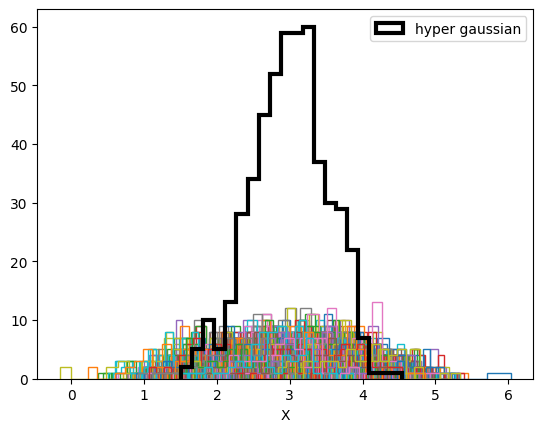

In [2]:
def generate_data(mean, scale, size):
    """
    Function to generate a Gaussian distribution with specified mean, scale and size. 
    """
    return np.random.normal(loc=mean, scale=scale, size=size)

# True parameters for the parent + child Gaussian distribution

true_parent_mean = 3.0 # hyperparameter
true_parent_scale = .5 # hyperparameter

true_child_scale = 0.5

N_obs = 500
size_child = 50

# Hypothesis for parent gaussian 
parent_gaussian = generate_data(true_parent_mean, true_parent_scale, size=N_obs)

# Add scatter on the child mean because the data for a signal is signal + noise
err_on_mean_child = np.expand_dims(np.random.randn(N_obs)/10, axis=1)
child_gaussian = np.random.normal(loc=parent_gaussian[:, np.newaxis] + err_on_mean_child, scale=true_child_scale, size=(N_obs, size_child))

for i in range(N_obs):
    plt.hist(child_gaussian[i], fill=False, histtype='step', bins=20)
plt.hist(parent_gaussian, fill=False, histtype='step', color='black',linewidth=3, label='hyper gaussian', bins=20)
plt.xlabel("X")
plt.legend()

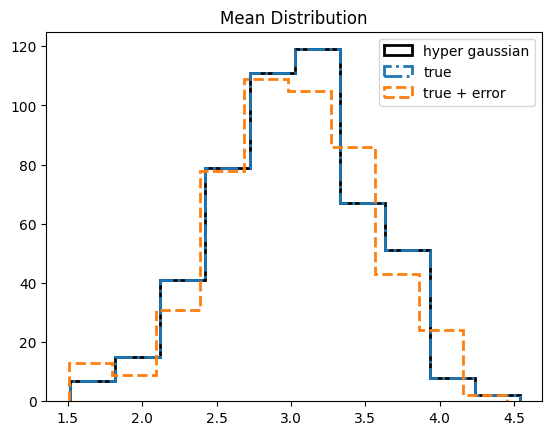

In [3]:
plt.hist(parent_gaussian, fill=False, histtype='step', color='black',linewidth=2, label='hyper gaussian')
plt.hist(parent_gaussian[:, np.newaxis], histtype='step', fill=False, label='true', linestyle='-.', linewidth=2)
plt.hist(parent_gaussian[:, np.newaxis] + err_on_mean_child, fill=False, histtype='step', label='true + error', linestyle='--', linewidth=2)
plt.title("Mean Distribution")
plt.legend()

In [4]:
def log_likelihood(params):
    parent_mean, parent_scale = params

    weights = np.log(np.sum(
                (2 * np.pi * true_child_scale**2)**(-0.5) * \
                np.exp(-(child_gaussian - np.expand_dims(child_gaussian.mean(axis=1), axis=1))**2 / \
                (2 * true_child_scale**2)),
                axis=1))
    chi_sq = ((child_gaussian.mean(axis=1) - parent_mean)**2 / (2 * parent_scale**2))
    
    return - 0.5 * N_obs * np.log(2 * np.pi * parent_scale**2 * size_child**2) - np.sum(chi_sq + weights)

In [5]:
from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([true_parent_mean, true_parent_scale]) + 0.1 * np.random.randn(2)
soln = minimize(nll, initial)
mu_ml, sigma_ml = soln.x
    
print("Maximum likelihood estimates:")
print("mu = {0:.3f}".format(mu_ml))
print("sigma = {0:.3f}".format(sigma_ml))

Maximum likelihood estimates:
mu = 2.993
sigma = 0.532


In [6]:
def log_prior(params):
    parent_mean, parent_scale = params
    # Flat priors 
    if (0 < parent_mean < 5 and 
        0 < parent_scale < 5):
        return 0.0
    return -np.inf

def log_probability(params):
    log_prior_val = log_prior(params)
    if not np.isfinite(log_prior_val):
        return -np.inf
    return log_prior_val + log_likelihood(params)

In [7]:
import emcee

pos = soln.x + 1e-6 * np.random.randn(50, 2)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability
)
sampler.run_mcmc(pos, 2000, progress=True)

100%|██████████| 2000/2000 [00:17<00:00, 116.02it/s]


State([[2.99024413 0.54320407]
 [2.9585399  0.51888157]
 [2.96048601 0.56248413]
 [2.99227277 0.52743363]
 [2.98951883 0.53660034]
 [2.99743892 0.56320183]
 [2.9541134  0.52223633]
 [3.02286114 0.56064291]
 [2.96276699 0.50493612]
 [2.98877975 0.53086151]
 [2.99421754 0.52200937]
 [3.00647679 0.51666699]
 [2.98550098 0.52581391]
 [2.97860065 0.55595745]
 [2.99072581 0.54856999]
 [3.0469257  0.50838235]
 [3.02553747 0.54697483]
 [3.00021816 0.54285417]
 [2.99626215 0.49349661]
 [3.00611639 0.52985968]
 [2.99647657 0.53601646]
 [2.98478103 0.52186403]
 [2.99675567 0.5353219 ]
 [2.94177674 0.54662873]
 [3.03366795 0.53497631]
 [3.00519966 0.54498616]
 [2.97531995 0.53189895]
 [2.9748852  0.53335097]
 [2.95523582 0.53190073]
 [3.01875067 0.58293375]
 [2.97238754 0.53666965]
 [2.96521037 0.51477895]
 [2.99409532 0.55471713]
 [3.01997743 0.53968615]
 [2.99418431 0.52718668]
 [2.9685687  0.5328071 ]
 [2.98816738 0.51106928]
 [2.95925605 0.53228496]
 [2.97928346 0.53340257]
 [2.99752572 0.5324

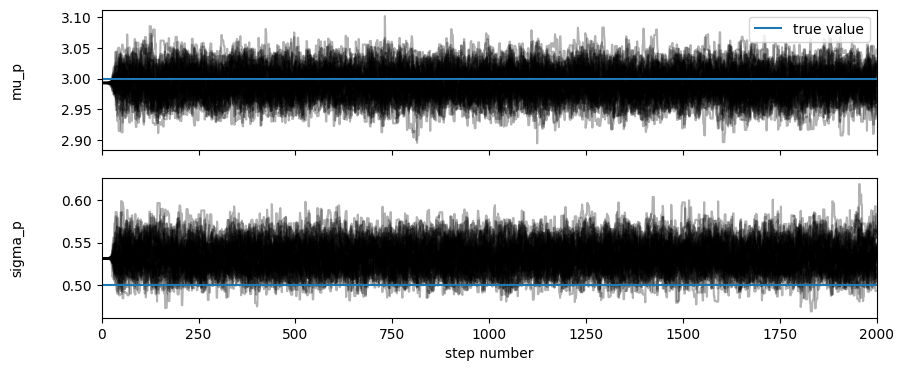

In [8]:
fig, axes = plt.subplots(2, figsize=(10, 4), sharex=True)
samples = sampler.get_chain()
labels = ["mu_p", "sigma_p"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[0].hlines(true_parent_mean, 0, len(samples), label="true value")
axes[1].hlines(true_parent_scale, 0, len(samples))
axes[-1].set_xlabel("step number")
axes[0].legend()

In [9]:
tau = sampler.get_autocorr_time()
print(tau)

[26.84091495 29.17452054]


In [10]:
flat_samples = sampler.get_chain(discard=50, thin=15, flat=True)
print(flat_samples.shape)

(6500, 2)


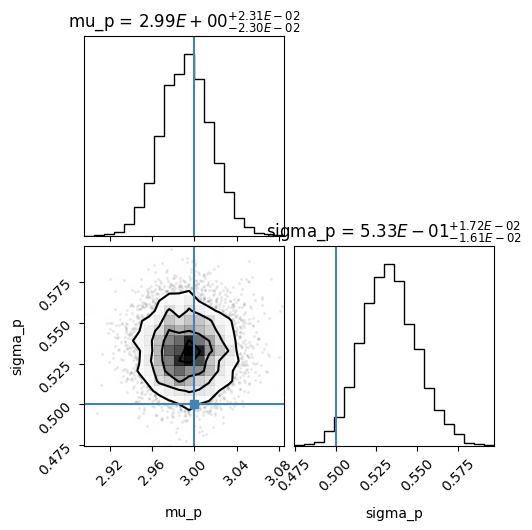

In [11]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[true_parent_mean, true_parent_scale], title_fmt=".2E", show_titles=True, title_kwargs={'fontsize':12}
)

## method - 2

In [12]:
import numpy as np
import emcee
import matplotlib.pyplot as plt

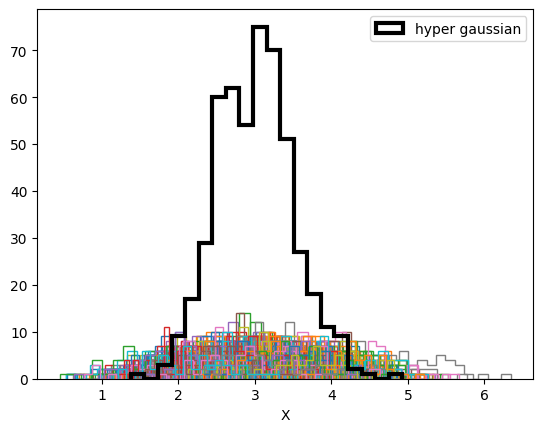

In [13]:
# True parameters for the parent + child Gaussian distribution

true_parent_mean = 3.0 # hyperparameter
true_parent_scale = .5 # hyperparameter

true_child_scale = 0.5

N_obs = 500
size_child = 50

# Hypothesis for parent gaussian 
parent_gaussian = np.random.normal(loc=true_parent_mean, scale=true_parent_scale, size=N_obs)

# Add scatter on the child mean because the data for a signal is signal + noise
err_on_mean_child = np.expand_dims(np.random.randn(N_obs)/10, axis=1)
child_gaussian = np.random.normal(loc=parent_gaussian[:, np.newaxis] + err_on_mean_child, scale=true_child_scale, size=(N_obs, size_child))

for i in range(N_obs):
    plt.hist(child_gaussian[i], fill=False, histtype='step', bins=20)
plt.hist(parent_gaussian, fill=False, histtype='step', color='black',linewidth=3, label='hyper gaussian', bins=20)
plt.xlabel("X")
plt.legend()

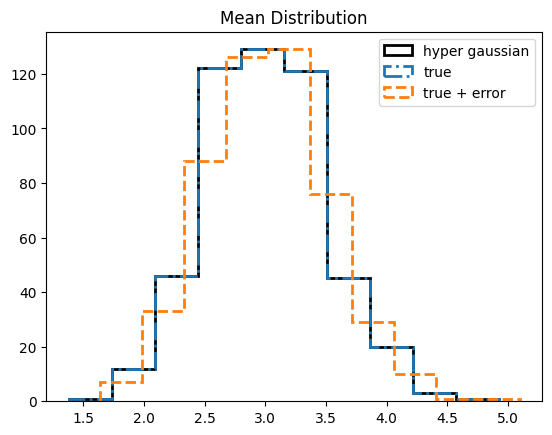

In [14]:
plt.hist(parent_gaussian, fill=False, histtype='step', color='black',linewidth=2, label='hyper gaussian')
plt.hist(parent_gaussian[:, np.newaxis], histtype='step', fill=False, label='true', linestyle='-.', linewidth=2)
plt.hist(parent_gaussian[:, np.newaxis] + err_on_mean_child, fill=False, histtype='step', label='true + error', linestyle='--', linewidth=2)
plt.title("Mean Distribution")
plt.legend()

In [15]:
posterior_child = lambda : (2 * np.pi * true_child_scale**2)**(-0.5) * np.exp(-(child_gaussian - np.expand_dims(child_gaussian.mean(axis=1), axis=1))**2 / (2 * true_child_scale**2))
model = lambda parent_mean, parent_scale : (2 * np.pi * parent_scale**2)**(-0.5) * np.exp(-(child_gaussian.mean(axis=1) - parent_mean)**2 / (2 * parent_scale**2)) * \
                                            size_child**-1 * np.sum(posterior_child(), axis=1)

def log_likelihood(params):
    parent_mean, parent_scale = params
    return np.log(np.product(model(parent_mean, parent_scale)))

In [16]:
from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([true_parent_mean, true_parent_scale]) + 0.1 * np.random.randn(2)
soln = minimize(nll, initial)
mu_ml, sigma_ml = soln.x
    
print("Maximum likelihood estimates:")
print("mu = {0:.3f}".format(mu_ml))
print("sigma = {0:.3f}".format(sigma_ml))

Maximum likelihood estimates:
mu = 3.013
sigma = 0.501


/tmp/ipykernel_26052/3247082190.py:7: RuntimeWarning: divide by zero encountered in log
  return np.log(np.product(model(parent_mean, parent_scale)))
/home/singh087/UofG/work/Code/HMtest/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/tmp/ipykernel_26052/3247082190.py:7: RuntimeWarning: divide by zero encountered in log
  return np.log(np.product(model(parent_mean, parent_scale)))


In [17]:
def log_prior(params):
    parent_mean, parent_scale = params
    # Flat priors 
    if (0 < parent_mean < 5 and 
        0 < parent_scale < 1):
        return 0.0
    return -np.inf

def log_probability(params):
    log_prior_val = log_prior(params)
    if not np.isfinite(log_prior_val):
        return -np.inf
    return log_prior_val + log_likelihood(params)

In [18]:
import emcee

pos = soln.x + 1e-6 * np.random.randn(50, 2)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability
)
sampler.run_mcmc(pos, 8000, progress=True)

100%|██████████| 8000/8000 [01:13<00:00, 108.58it/s]


State([[3.02051749 0.5043101 ]
 [2.98956822 0.5051    ]
 [2.98074685 0.50695102]
 [3.00013478 0.52019009]
 [2.98609483 0.49960984]
 [2.98197676 0.52428852]
 [2.99884363 0.50535578]
 [3.00443097 0.5195152 ]
 [3.00751734 0.51670799]
 [3.04625188 0.49325019]
 [3.00369963 0.50083587]
 [3.02294379 0.51660265]
 [3.03578823 0.53398377]
 [3.04476289 0.52874634]
 [3.0153969  0.49710603]
 [3.00544153 0.53725315]
 [2.99866608 0.51383733]
 [3.00750216 0.49670487]
 [3.00497342 0.48906877]
 [2.98097493 0.48068493]
 [3.01115459 0.4859719 ]
 [2.99814428 0.50454094]
 [2.99937925 0.50921589]
 [3.01006207 0.50548214]
 [3.01607882 0.52003283]
 [2.99330726 0.51803891]
 [3.01607086 0.485248  ]
 [3.00701764 0.48927409]
 [3.0053652  0.50094902]
 [3.01806419 0.52213092]
 [3.00449446 0.48839381]
 [3.00656452 0.51123608]
 [3.00965277 0.48173648]
 [3.042819   0.51258154]
 [3.01742031 0.51337495]
 [2.96528152 0.5171512 ]
 [2.98709428 0.52244125]
 [3.04583131 0.52725085]
 [3.01285368 0.52092548]
 [3.01247426 0.4771

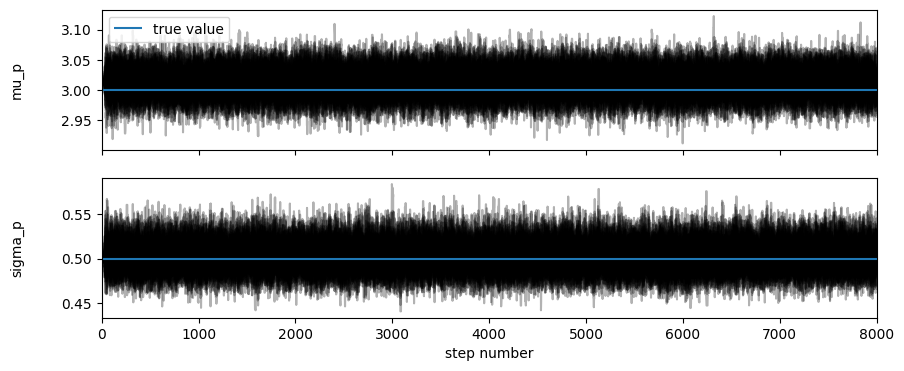

In [19]:
fig, axes = plt.subplots(2, figsize=(10, 4), sharex=True)
samples = sampler.get_chain()
labels = ["mu_p", "sigma_p"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[0].hlines(true_parent_mean, 0, len(samples), label="true value")
axes[1].hlines(true_parent_scale, 0, len(samples))
axes[-1].set_xlabel("step number")
axes[0].legend()

In [20]:
tau = sampler.get_autocorr_time()
print(tau)

[31.17864383 31.28798031]


In [21]:
flat_samples = sampler.get_chain(discard=50, thin=15, flat=True)
print(flat_samples.shape)

(26500, 2)


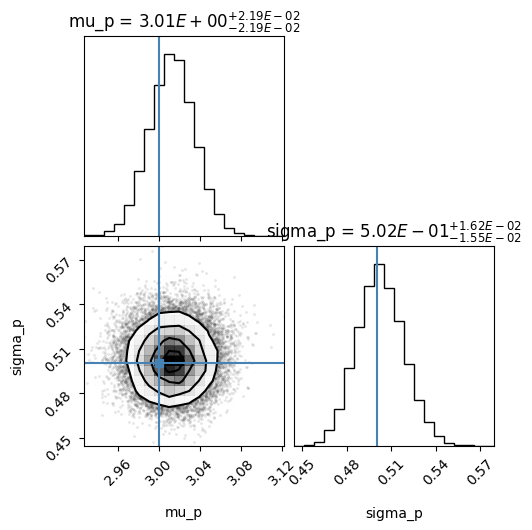

In [22]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[true_parent_mean, true_parent_scale], title_fmt=".2E", show_titles=True, title_kwargs={'fontsize':12}
)

# BIMODAL HM (analytical calculation is not done)

In [23]:
import numpy as np
import emcee
import matplotlib.pyplot as plt

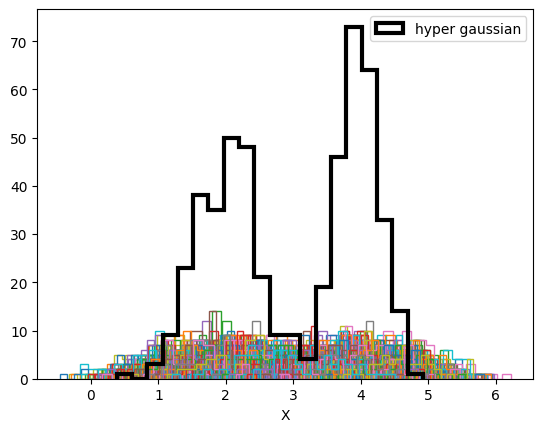

In [24]:
N_obs = 500
size_child = 50

true_parent_mean_A = 2.0 # hyperparameter
true_parent_scale_A = .5 # hyperparameter
true_parent_mean_B = 4.0 # hyperparameter
true_parent_scale_B = .3 # hyperparameter

true_child_scale = 0.5

parent_gaussian = np.concatenate((np.random.normal(loc=true_parent_mean_A, scale=true_parent_scale_A, size=N_obs//2), 
                                  np.random.normal(loc=true_parent_mean_B, scale=true_parent_scale_B, size=N_obs//2)),
                                )

# Add scatter on the child mean because the data for a signal is signal + noise
err_on_mean_child = np.expand_dims(np.random.randn(N_obs)/10, axis=1)
child_gaussian = np.random.normal(loc=parent_gaussian[:, np.newaxis] + err_on_mean_child, scale=true_child_scale, size=(N_obs, size_child))

for i in range(N_obs):
    plt.hist(child_gaussian[i], fill=False, histtype='step', bins=20)
plt.hist(parent_gaussian, fill=False, histtype='step', color='black',linewidth=3, label='hyper gaussian', bins=20)
plt.xlabel("X")
plt.legend()

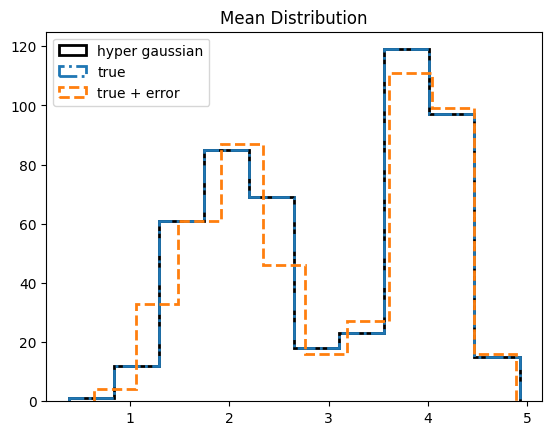

In [25]:
plt.hist(parent_gaussian, fill=False, histtype='step', color='black',linewidth=2, label='hyper gaussian')
plt.hist(parent_gaussian[:, np.newaxis], histtype='step', fill=False, label='true', linestyle='-.', linewidth=2)
plt.hist(parent_gaussian[:, np.newaxis] + err_on_mean_child, fill=False, histtype='step', label='true + error', linestyle='--', linewidth=2)
plt.title("Mean Distribution")
plt.legend()

In [26]:
posterior_child = lambda : (2 * np.pi * true_child_scale**2)**(-0.5) * np.exp(-(child_gaussian - np.expand_dims(child_gaussian.mean(axis=1), axis=1))**2 / (2 * true_child_scale**2))
model = lambda parent_mean_A, parent_scale_A, parent_mean_B, parent_scale_B : (
                                (2 * np.pi * parent_scale_A**2)**(-0.5) * np.exp(-(child_gaussian.mean(axis=1) - parent_mean_A)**2 / (2 * parent_scale_A**2)) + \
                                (2 * np.pi * parent_scale_B**2)**(-0.5) * np.exp(-(child_gaussian.mean(axis=1) - parent_mean_B)**2 / (2 * parent_scale_B**2))
                                ) * \
                                            size_child**-1 * np.sum(posterior_child(), axis=1)

def log_likelihood(params):
    parent_mean_A, parent_scale_A, parent_mean_B, parent_scale_B = params
    return np.log(np.product(model(parent_mean_A, parent_scale_A, parent_mean_B, parent_scale_B)))

In [27]:
from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([true_parent_mean_A, true_parent_scale_A, true_parent_mean_B, true_parent_scale_B]) + 0.1 * np.random.randn(4)
soln = minimize(nll, initial)
mu_A_ml, sigma_A_ml, mu_B_ml, sigma_B_ml = soln.x
    
print("Maximum likelihood estimates:")
print("mu_A = {0:.3f}".format(mu_A_ml))
print("sigma_A = {0:.3f}".format(sigma_A_ml))
print("mu_B = {0:.3f}".format(mu_B_ml))
print("sigma_B = {0:.3f}".format(sigma_B_ml))

Maximum likelihood estimates:
mu_A = 2.009
sigma_A = 0.471
mu_B = 3.998
sigma_B = 0.323


/tmp/ipykernel_26052/2896788237.py:10: RuntimeWarning: divide by zero encountered in log
  return np.log(np.product(model(parent_mean_A, parent_scale_A, parent_mean_B, parent_scale_B)))
/home/singh087/UofG/work/Code/HMtest/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/tmp/ipykernel_26052/2896788237.py:10: RuntimeWarning: divide by zero encountered in log
  return np.log(np.product(model(parent_mean_A, parent_scale_A, parent_mean_B, parent_scale_B)))


In [28]:
def log_prior(params):
    parent_mean_A, parent_scale_A, parent_mean_B, parent_scale_B = params
    # Flat priors 
    if (0 < parent_mean_A < 5 and 
        0 < parent_scale_A < 1 and
        0 < parent_mean_B < 5 and 
        0 < parent_scale_B < 1):
        return 0.0
    return -np.inf

def log_probability(params):
    log_prior_val = log_prior(params)
    if not np.isfinite(log_prior_val):
        return -np.inf
    return log_prior_val + log_likelihood(params)

In [29]:
import emcee

pos = soln.x + 1e-6 * np.random.randn(50, 4)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability
)
sampler.run_mcmc(pos, 8000, progress=True)

 28%|██▊       | 2205/8000 [00:20<00:53, 108.05it/s]

In [ ]:
fig, axes = plt.subplots(4, figsize=(10, 6), sharex=True)
samples = sampler.get_chain()
labels = ["mu_A", "sigma_A", "mu_B", "sigma_B"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")
axes[0].hlines(true_parent_mean_A, 0, len(samples), label="true value")
axes[1].hlines(true_parent_scale_A, 0, len(samples))
axes[2].hlines(true_parent_mean_B, 0, len(samples))
axes[3].hlines(true_parent_scale_B, 0, len(samples))

In [ ]:
tau = sampler.get_autocorr_time()
print(tau)

In [ ]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

In [ ]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[true_parent_mean_A, true_parent_scale_A, true_parent_mean_B, true_parent_scale_B], title_fmt=".2E", show_titles=True, title_kwargs={'fontsize':12}
)

# Power law 

In [ ]:
import numpy as np
import emcee
import matplotlib.pyplot as plt

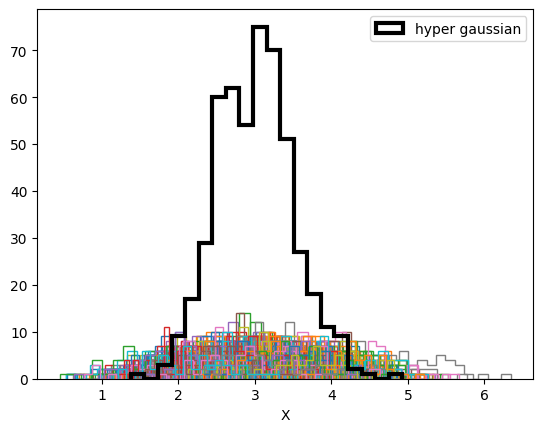

In [ ]:
# True parameters for the parent + child Gaussian distribution

true_parent_mean = 3.0 # hyperparameter
true_parent_scale = .5 # hyperparameter

true_child_scale = 0.5

N_obs = 500
size_child = 50

# Hypothesis for parent gaussian 
parent_gaussian = np.random.normal(loc=true_parent_mean, scale=true_parent_scale, size=N_obs)

# Add scatter on the child mean because the data for a signal is signal + noise
err_on_mean_child = np.expand_dims(np.random.randn(N_obs)/10, axis=1)
child_gaussian = np.random.normal(loc=parent_gaussian[:, np.newaxis] + err_on_mean_child, scale=true_child_scale, size=(N_obs, size_child))

for i in range(N_obs):
    plt.hist(child_gaussian[i], fill=False, histtype='step', bins=20)
plt.hist(parent_gaussian, fill=False, histtype='step', color='black',linewidth=3, label='hyper gaussian', bins=20)
plt.xlabel("X")
plt.legend()

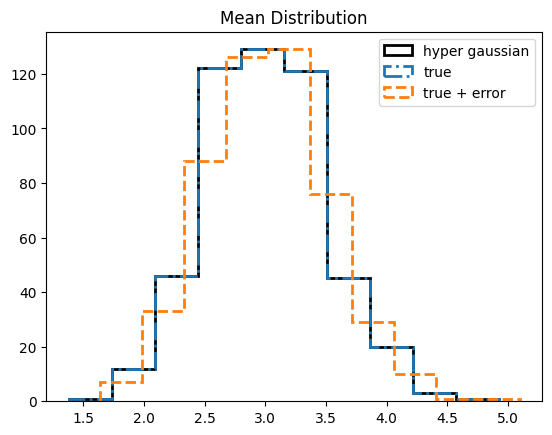

In [ ]:
plt.hist(parent_gaussian, fill=False, histtype='step', color='black',linewidth=2, label='hyper gaussian')
plt.hist(parent_gaussian[:, np.newaxis], histtype='step', fill=False, label='true', linestyle='-.', linewidth=2)
plt.hist(parent_gaussian[:, np.newaxis] + err_on_mean_child, fill=False, histtype='step', label='true + error', linestyle='--', linewidth=2)
plt.title("Mean Distribution")
plt.legend()

In [ ]:
posterior_child = lambda : (2 * np.pi * true_child_scale**2)**(-0.5) * np.exp(-(child_gaussian - np.expand_dims(child_gaussian.mean(axis=1), axis=1))**2 / (2 * true_child_scale**2))
model = lambda parent_mean, parent_scale : (2 * np.pi * parent_scale**2)**(-0.5) * np.exp(-(child_gaussian.mean(axis=1) - parent_mean)**2 / (2 * parent_scale**2)) * \
                                            size_child**-1 * np.sum(posterior_child(), axis=1)

def log_likelihood(params):
    parent_mean, parent_scale = params
    return np.log(np.product(model(parent_mean, parent_scale)))

In [ ]:
from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([true_parent_mean, true_parent_scale]) + 0.1 * np.random.randn(2)
soln = minimize(nll, initial)
mu_ml, sigma_ml = soln.x
    
print("Maximum likelihood estimates:")
print("mu = {0:.3f}".format(mu_ml))
print("sigma = {0:.3f}".format(sigma_ml))

Maximum likelihood estimates:
mu = 3.013
sigma = 0.501


/tmp/ipykernel_26052/3247082190.py:7: RuntimeWarning: divide by zero encountered in log
  return np.log(np.product(model(parent_mean, parent_scale)))
/home/singh087/UofG/work/Code/HMtest/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/tmp/ipykernel_26052/3247082190.py:7: RuntimeWarning: divide by zero encountered in log
  return np.log(np.product(model(parent_mean, parent_scale)))


In [ ]:
def log_prior(params):
    parent_mean, parent_scale = params
    # Flat priors 
    if (0 < parent_mean < 5 and 
        0 < parent_scale < 1):
        return 0.0
    return -np.inf

def log_probability(params):
    log_prior_val = log_prior(params)
    if not np.isfinite(log_prior_val):
        return -np.inf
    return log_prior_val + log_likelihood(params)

In [ ]:
import emcee

pos = soln.x + 1e-6 * np.random.randn(50, 2)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability
)
sampler.run_mcmc(pos, 8000, progress=True)

100%|██████████| 8000/8000 [01:13<00:00, 108.58it/s]


In [ ]:
fig, axes = plt.subplots(2, figsize=(10, 4), sharex=True)
samples = sampler.get_chain()
labels = ["mu_p", "sigma_p"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[0].hlines(true_parent_mean, 0, len(samples), label="true value")
axes[1].hlines(true_parent_scale, 0, len(samples))
axes[-1].set_xlabel("step number")
axes[0].legend()

In [ ]:
tau = sampler.get_autocorr_time()
print(tau)

In [ ]:
flat_samples = sampler.get_chain(discard=50, thin=15, flat=True)
print(flat_samples.shape)

In [ ]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[true_parent_mean, true_parent_scale], title_fmt=".2E", show_titles=True, title_kwargs={'fontsize':12}
)